In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import datetime
import json
# from underthesea import word_tokenize
from vncorenlp import VnCoreNLP
import string
import textstat
from underthesea import sentiment

# Load train and test data

In [2]:
train_df = pd.read_csv('data/public_train_ext.csv')
test_df = pd.read_csv('data/final_private_test_dropped_no_label.csv')

In [3]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1646 non-null   int64  
 1   user_name         1646 non-null   object 
 2   post_message      1646 non-null   object 
 3   timestamp_post    1612 non-null   float64
 4   num_like_post     1030 non-null   float64
 5   num_comment_post  969 non-null    object 
 6   num_share_post    904 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 90.1+ KB


# VnCoreNLP

In [4]:
annotator = VnCoreNLP("./VnCoreNLP/VnCoreNLP-1.1.1.jar", annotators="wseg,pos")

In [5]:
annotator.tokenize("đạihọcHoaSen")

[['đạihọcHoaSen']]

In [6]:
annotator.pos_tag('VTV đồng ý chia sẻ bản quyền World Cup 2018 cho HTV để khai thác.')

[[('VTV', 'Ny'),
  ('đồng_ý', 'V'),
  ('chia_sẻ', 'V'),
  ('bản_quyền', 'N'),
  ('World_Cup', 'N'),
  ('2018', 'M'),
  ('cho', 'E'),
  ('HTV', 'Ny'),
  ('để', 'E'),
  ('khai_thác', 'V'),
  ('.', 'CH')]]

# Handle disorder feature

In [7]:
def extract_number(s):
    if (type(s) == str):
        if (len(re.findall('(?:[+-]?(?:[0-9]+))', s)) > 0):
            print(s)
            return int(re.findall('(?:[+-]?(?:[0-9]+))', s)[0])
        else:
            return -999
    else:
        return s
    
def is_digit(n):
    try:
        float(n)
        return True
    except ValueError:
        return  False
    
def handle_num_like_post(s):
    if (type(s) == str):
        if ('like' in s):
            return int(s.split(" ")[0])
        if (not is_digit(s)):
            return -999
        else:
            return s
    return s

def handle_num_comment_post(s):
    if (type(s) == str):
        if ('comment' in s):
            return int(s.split(" ")[0])
        if (not is_digit(s)):
            return -999
        else:
            return s
    return s

def handle_num_share_post(s):
    if (type(s) == str):
        if ('share' in s):
            return int(s.split(" ")[0])
        if (not is_digit(s)):
            return -999
        else:
            return s
    return s

In [8]:
fe_train_df = train_df.copy()

fe_train_df[['num_like_post', 'num_comment_post', 'num_share_post']] = fe_train_df[['num_like_post', 'num_comment_post', 'num_share_post']].replace('unknown', np.nan)
fe_train_df[['num_like_post', 'num_comment_post', 'num_share_post']] = fe_train_df[['num_like_post', 'num_comment_post', 'num_share_post']].fillna('-999')

<AxesSubplot:ylabel='label'>

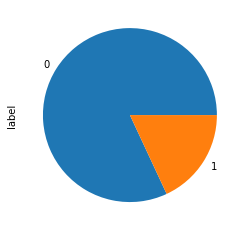

In [10]:
fe_train_df['label'].value_counts().plot(kind='pie')

## Find and handle data point with unusual type

In [11]:
fe_train_df.loc[~fe_train_df['num_like_post'].apply(is_digit), :]

,id,user_name,post_message,timestamp_post,num_like_post,num_comment_post,num_share_post,label
132,132,4.16347197306717e+18,Hôm nay ra chợ em đã nghe mọi người kháo nhau....,1584514800.0,54 like,20,12,1
881,82,f8584733a5e8e99a9b45ebb5400e796e,MU nhuộm đỏ thành Manchester,Ronaldo lập cột mốc khó tin,Solskjaer hạ knock-out Guardiola,Juventus bỏ xa Inter Milan... là những ảnh ch...,1583713929.0,0
2512,1713,c25879ff6975b91d35be50379b90177a,Giá vàng hôm nay: Tăng hơn 1 triệu đồng mỗi lượng,Giá vàng thế giới vọt 3% sau khi FED hạ lãi suất,Ngang nhiên chiếm dụng đất dự án hồ Yên Sở là...,1583307918,7.0,0
2633,1834,7ac71da7c5675e5758bf798fa4b344d5,Hôm nay ra chợ em đã nghe mọi người kháo nhau....,1584514800.0,54 like,20,12,1
3972,3173,c9345dce3690bf6c775fca746467ff84,Vụ voi ăn dứa nhồi pháo: Kết quả điều tra chín...,Công bố phát hiện bất ngờ về COVID-19 ở Vũ Hán,Kết quả phiên xử đầu tiên cảnh sát Mỹ ghì chế...,1591690549,9.0,0
4290,3491,c9345dce3690bf6c775fca746467ff84,Nhiều quốc gia đặt mua kit xét nghiệm COVID-19...,2 bệnh nhân mắc COVID-19 nặng ở Việt Nam tiến...,Thế giới đẩy nhanh tốc độ phát triển vaccine ...,1584428863,53.0,0


In [12]:
fe_train_df.loc[~fe_train_df['num_comment_post'].apply(is_digit), :]

,id,user_name,post_message,timestamp_post,num_like_post,num_comment_post,num_share_post,label
38,38,-3.73179367436277e+18,Phó Chủ tịch Thường trực UBND TPHCM Lê Thanh L...,1585559940.0,16,1 comment,0,1
51,51,6.57907768560358e+18,Lô thuốc đầu tiên chữa khỏi bệnh viêm phổi vi...,1584542160.0,12,1 comment,0,1
160,160,-3.44009624305453e+18,Tỷ phú Bill Gates là người tung virus corona. ...,1580884680.0,21,1 comment,0,1
881,82,f8584733a5e8e99a9b45ebb5400e796e,MU nhuộm đỏ thành Manchester,Ronaldo lập cột mốc khó tin,Solskjaer hạ knock-out Guardiola,Juventus bỏ xa Inter Milan... là những ảnh ch...,1583713929.0,0
989,190,a2ed99660efc25ebf7dd8947c046fd4c,Hà Nội đã hoãn giải đua F1 do dịch Covid-19,1583595360.0,29,1 comment,0,0
1098,299,6585dc84a464f35eb5dbbf7dc2c4ce2a,Phó Chủ tịch Thường trực UBND TPHCM Lê Thanh L...,1585559940.0,16,1 comment,0,1
3078,2279,d089c8b4589107ad5d44620c09e1e348,NGHI NGỜ VIRUS 2019-nCoV LÀ VŨ KHÍ SINH HỌC.\n...,1580885280.0,20,1 comment,6,1
3519,2720,da714923622c349f0c40eab8ef52db95,"""Thảo nào tôi đã không bị rụng tóc"" - Tổng thố...",1601315280.0,120,10 comment,2,1
4012,3213,fba7ff4245f1a93bca836e76a079543c,Lô thuốc đầu tiên chữa khỏi bệnh viêm phổi vi...,1584542160.0,12,1 comment,0,1
4338,3539,82636849e8933b59ebab10bc26cc59fc,Thời gian qua dịch tả lợn Chây Phi đang gây ản...,1551688080.0,116,12 comment,0,1


In [13]:
fe_train_df.loc[~fe_train_df['num_share_post'].apply(is_digit), :]

,id,user_name,post_message,timestamp_post,num_like_post,num_comment_post,num_share_post,label
6,6,-4.2367642143239e+18,"TIN CHẤN ĐỘNG , NHÂN LOẠI ĐƯỢC CỨU\n\n100% ngư...",1584717660.0,21,5,1 share,1
58,58,9.03153076886958e+18,Người đàn ông Hồi giáo tươi cười khi nhà thờ Đ...,1586963340.0,82,13,1 share,1
62,62,-1.94635499876047e+18,Ngay cả khi vi-rút xâm nhập vào miệng bạn ... ...,1582995240.0,17,2,1 share,1
178,178,-4.10417173654197e+18,Bcao cô và các bố mẹ! E vừa dự cuộc họp khẩn c...,1584519300.0,55,4,1 share,1
182,182,1.31978032864379e+17,Tối nay từ 11:40 tối không ai nên đi ra đường....,1585459380.0,70,5,1 share,1
186,186,-6.85276306603655e+18,BÀI THUỐC MỖI SÁNG KHIẾN TÔI KHỎE MẠNH\n\nKhuy...,1588160100.0,10,5,1 share,1
432,432,-1.16192268385204e+18,Sở GD&ĐT Hải Phòng đã có chỉ đạo tới các trườn...,NaN,-999,1,"May 25th 2020, 21:57:58.000",0
1188,389,16244723c53210008d58c2f9f2b14d29,Mọi người cảnh giác nhé… trưa hôm nay cô mình ...,1552226820.0,91,33,1 share,1
1721,922,4196a8c1ae87dfaa0a3b0bbde0a27ea1,"Thuốc chữa sốt rét chữa Covid-19. Ở Mỹ, Trung ...",1584992460.0,55,24,1 share,1
1910,1111,fbf45c6879a5296c35d75a08e123ada6,Nhóm du khách Hàn Quốc sau khi từ chối cách ly...,1582729860.0,32,22,1 share,1


In [14]:
fe_train_df.loc[~fe_train_df['timestamp_post'].apply(is_digit), :]

,id,user_name,post_message,timestamp_post,num_like_post,num_comment_post,num_share_post,label
881,82,f8584733a5e8e99a9b45ebb5400e796e,MU nhuộm đỏ thành Manchester,Ronaldo lập cột mốc khó tin,Solskjaer hạ knock-out Guardiola,Juventus bỏ xa Inter Milan... là những ảnh ch...,1583713929.0,0
1391,592,f0ada4801309678b82743587f9b9c5f2,Học sinh từ lớp 5 trở lên đi học trở lại từ ng...,từ lớp 1 đến lớp 4 tiếp tục đi học từ ngày ...,1587881185,24,1.0,0
2512,1713,c25879ff6975b91d35be50379b90177a,Giá vàng hôm nay: Tăng hơn 1 triệu đồng mỗi lượng,Giá vàng thế giới vọt 3% sau khi FED hạ lãi suất,Ngang nhiên chiếm dụng đất dự án hồ Yên Sở là...,1583307918,7.0,0
2723,1924,c9345dce3690bf6c775fca746467ff84,2 thanh niên nhập viện cấp cứu sau tai nạn liê...,Hà Nội: Nguy hiểm cận kề từ họp chợ tràn ra l...,1592283607,4,0.0,0
3392,2593,43c8a5fff1569c42948813f533e5cf24,Bản tin cập nhật tình hình dịch bệnh do Virus ...,Nhộn nhịp mùa đánh bắt cá mú đỏ…,1585172827,1276,2.0,0
3972,3173,c9345dce3690bf6c775fca746467ff84,Vụ voi ăn dứa nhồi pháo: Kết quả điều tra chín...,Công bố phát hiện bất ngờ về COVID-19 ở Vũ Hán,Kết quả phiên xử đầu tiên cảnh sát Mỹ ghì chế...,1591690549,9.0,0
4290,3491,c9345dce3690bf6c775fca746467ff84,Nhiều quốc gia đặt mua kit xét nghiệm COVID-19...,2 bệnh nhân mắc COVID-19 nặng ở Việt Nam tiến...,Thế giới đẩy nhanh tốc độ phát triển vaccine ...,1584428863,53.0,0
5019,4220,c9345dce3690bf6c775fca746467ff84,Vợ Đường Nhuệ vừa bị khởi tố thêm tội danh gì,Một hộ dân “sốc” với gần 90 triệu tiền điện t...,1592811050,11,0.0,0


In [15]:
fe_train_df[fe_train_df['timestamp_post'].isna()]

,id,user_name,post_message,timestamp_post,num_like_post,num_comment_post,num_share_post,label
75,75,1.29415859129534e+18,Tin nhé cả nhà 👏 Niệm thần chú cho mau hết bện...,NaN,53,46,117,1
139,139,-7.20760366592662e+17,BA XÁC CHẾT ĐƯỢC ĐẶT VÀO TRONG MỘT BAO .. 3 đứ...,NaN,1500,3500,13000,1
253,253,-7.80696059149588e+18,TIN NÓNG: BRVT CÓ 1 NGƯỜI NHIỄM CÚM A/H1N1 Vào...,NaN,1200,835,2300,0
254,254,7.05044402105848e+18,Bản tin Toàn cảnh phòng chống dịch nCoV ngày 9...,NaN,15000,513,2300,0
256,256,-5.34265939776517e+18,Dẫn dòng trạng thái đăng trên mạng xã hội Twit...,NaN,4300,260,4200,0
...,...,...,...,...,...,...,...,...
4995,4196,b2d8d985c06b203fed093e52008aa64f,PHÁT MIỄN PHÍ HÀNG TRIỆU KHẨU TRANG VẢI ĐỂ NGƯ...,NaN,3000,974,4300,0
5023,4224,1e44dc26ec7db8eb95fe352ff385b2c5,"🇻🇳🇻🇳🇻🇳🇻🇳 'Việt Nam hỡi, Việt Nam ơi! Cùng đoà...",NaN,1100,109,2200,0
5057,4258,50d80468b93b3eaaa6f907f6d5274022,"Moderna Therapetics, một công ty công nghệ sin...",NaN,18000,1300,26000,0
5102,4303,c76936b0e080d87f5ea552844b158da1,"Fang Bin, một cư dân Vũ Hán, đã bí mật gắn máy...",NaN,4400,976,4400,1


In [16]:
fe_train_df['num_like_post'] = fe_train_df['num_like_post'].apply(handle_num_like_post).astype(float)
fe_train_df['num_comment_post'] = fe_train_df['num_comment_post'].apply(handle_num_comment_post).astype(float)
fe_train_df['num_share_post'] = fe_train_df['num_share_post'].apply(handle_num_share_post).astype(float)

In [17]:
fe_train_df.loc[fe_train_df['num_like_post'] > 150000000, 'timestamp_post'] = fe_train_df[fe_train_df['num_like_post'] > 150000000]['num_like_post']
fe_train_df.loc[fe_train_df['num_like_post'] > 150000000, 'num_like_post'] = -999

fe_train_df.loc[fe_train_df['num_comment_post'] > 150000000, 'timestamp_post'] = fe_train_df[fe_train_df['num_comment_post'] > 150000000]['num_comment_post']
fe_train_df.loc[fe_train_df['num_comment_post'] > 150000000, 'num_comment_post'] = -999

fe_train_df.loc[fe_train_df['num_share_post'] > 150000000, 'timestamp_post'] = fe_train_df[fe_train_df['num_share_post'] > 150000000]['num_share_post']
fe_train_df.loc[fe_train_df['num_share_post'] > 150000000, 'num_share_post'] = -999

Text(0.5, 1.0, 'Label = 1 Num_share_post')

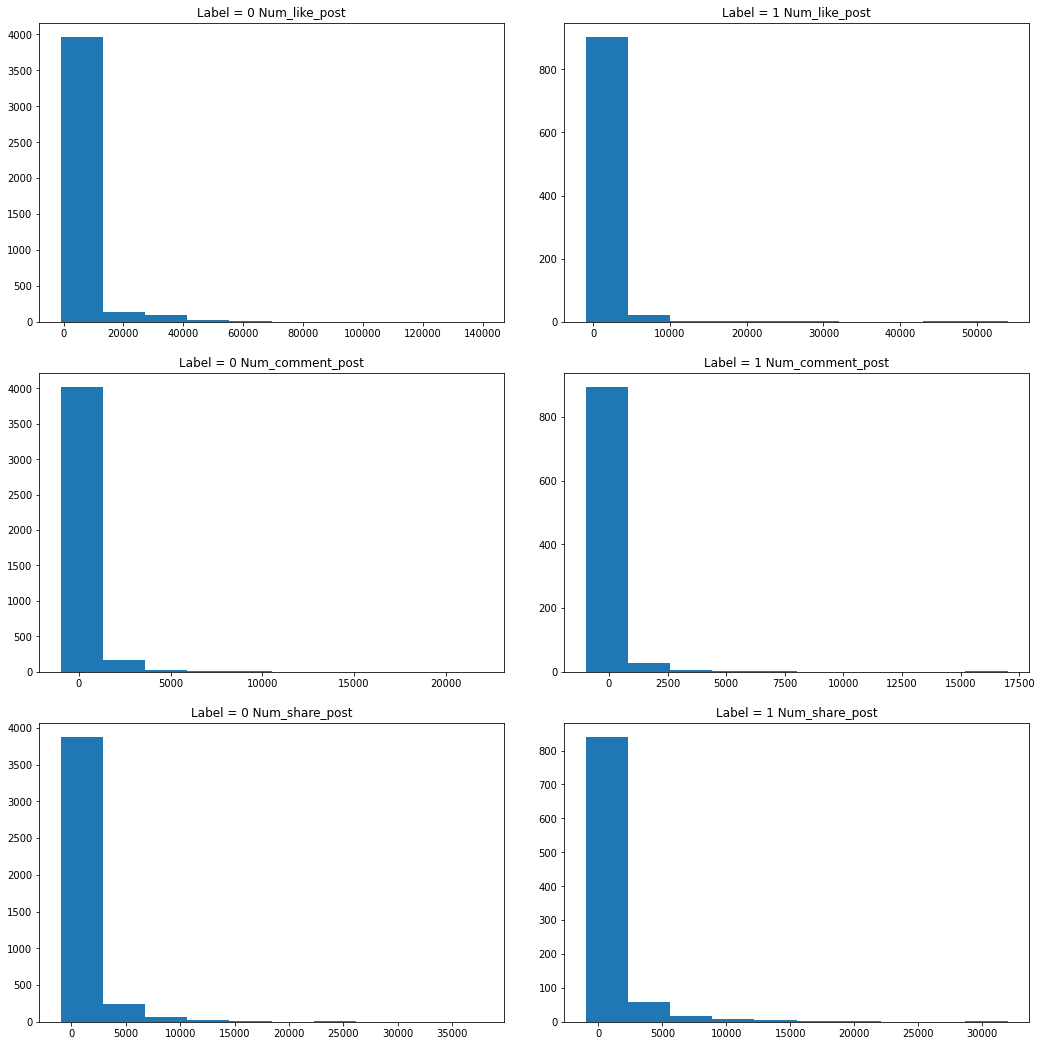

In [18]:
fig, ax = plt.subplots(3, 2, figsize=(15,15))
fig.tight_layout(pad=3.0)
ax[0, 0].hist(fe_train_df[fe_train_df['label'] == 0]['num_like_post'])
ax[0, 0].set_title('Label = 0 Num_like_post')
ax[0, 1].hist(fe_train_df[fe_train_df['label'] == 1]['num_like_post'])
ax[0, 1].set_title('Label = 1 Num_like_post')
ax[1, 0].hist(fe_train_df[fe_train_df['label'] == 0]['num_comment_post'])
ax[1, 0].set_title('Label = 0 Num_comment_post')
ax[1, 1].hist(fe_train_df[fe_train_df['label'] == 1]['num_comment_post'])
ax[1, 1].set_title('Label = 1 Num_comment_post')

ax[2, 0].hist(fe_train_df[fe_train_df['label'] == 0]['num_share_post'])
ax[2, 0].set_title('Label = 0 Num_share_post')
ax[2, 1].hist(fe_train_df[fe_train_df['label'] == 1]['num_share_post'])
ax[2, 1].set_title('Label = 1 Num_share_post')

In general, true post have more comment and like.

## Propagation of user (How many time people post?)

In [20]:
print('There is', fe_train_df['user_name'].nunique(), "unique user")

There is 3706 unique user


In [21]:
unique_user = fe_train_df['user_name'].value_counts()

In [22]:
fe_train_df['num_post'] = fe_train_df['user_name'].map(unique_user)

In [23]:
# fe_train_df['num_post'].hist()
fe_train_df[fe_train_df['label'] == 0]['num_post'].mean()

12.86101934874941

In [24]:
fe_train_df[fe_train_df['label'] == 1]['num_post'].mean()

1.467880085653105

People who post real news tend to post more

In [25]:
multi_post_user = fe_train_df[fe_train_df['user_name'].apply(lambda x: x in unique_user[unique_user > 1].keys())]

<AxesSubplot:xlabel='count', ylabel='mean'>

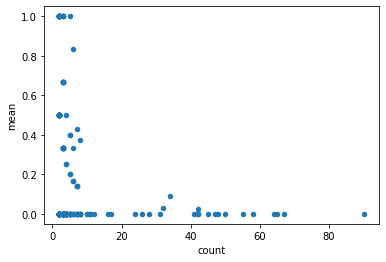

In [26]:
multi_post_user.groupby('user_name')['label'].agg(['count', 'mean']).sort_values(by='count', ascending=False).plot(kind='scatter', x='count', y='mean')

People who post less tend to post fake news

# Handle datetime

In [27]:
fe_train_df['timestamp_post'] = pd.to_datetime(fe_train_df['timestamp_post'], unit='s')

In [28]:
fe_train_df['timestamp_post']

0      2020-03-17 06:20:00
1      2020-02-10 19:25:36
2      2020-04-16 12:53:00
3      2020-08-03 10:08:00
4      2020-03-07 02:28:00
               ...        
5167   2020-03-21 12:52:06
5168   2020-05-28 06:00:43
5169   2020-05-18 04:00:21
5170   2020-05-15 14:03:27
5171   2020-06-28 04:41:22
Name: timestamp_post, Length: 5172, dtype: datetime64[ns]

In [29]:
# shamelessly copy from https://stackoverflow.com/questions/55571311/get-part-of-day-morning-afternoon-evening-night-in-python-dataframe
def session_of_day(x):
    if (isinstance(x, float)):
        if (x > 4) and (x <= 8):
            return 0 #'Early Morning'
        elif (x > 8) and (x <= 12 ):
            return 1 #'Morning'
        elif (x > 12) and (x <= 16):
            return 2 #'Noon'
        elif (x > 16) and (x <= 20) :
            return 3 #'Eve'
        elif (x > 20) and (x <= 24):
            return 4 #'Night'
        elif (x <= 4):
            return 5 #'Late Night'
    return -1

# is_busday(fe_train_df['timestamp_post'].iloc[1])
fe_train_df['month_post'] = fe_train_df['timestamp_post'].dt.month
fe_train_df['day_post'] = fe_train_df['timestamp_post'].dt.day
fe_train_df['weekday_post'] = fe_train_df['timestamp_post'].dt.weekday
fe_train_df['hour_post'] = fe_train_df['timestamp_post'].dt.hour
fe_train_df['session_of_day'] = fe_train_df['hour_post'].apply(session_of_day)

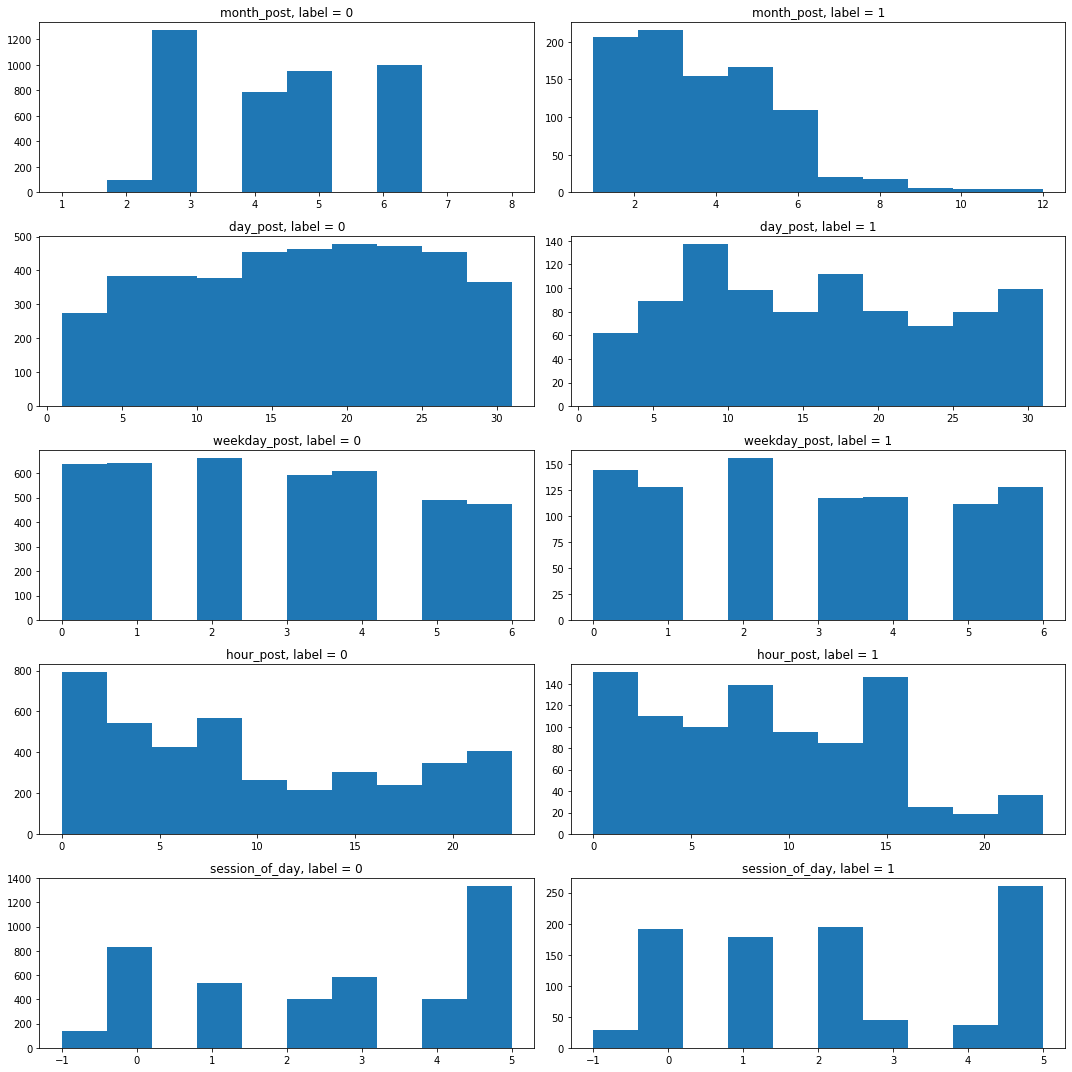

In [30]:
fig, ax = plt.subplots(5, 2, figsize=(15, 15))
ax[0, 0].hist(fe_train_df[fe_train_df['label'] == 0].month_post.to_numpy())
ax[0, 0].set_title('month_post, label = 0')
ax[0, 1].hist(fe_train_df[fe_train_df['label'] == 1].month_post.to_numpy())
ax[0, 1].set_title('month_post, label = 1')
ax[1, 0].hist(fe_train_df[fe_train_df['label'] == 0].day_post.to_numpy())
ax[1, 0].set_title('day_post, label = 0')
ax[1, 1].hist(fe_train_df[fe_train_df['label'] == 1].day_post.to_numpy())
ax[1, 1].set_title('day_post, label = 1')
ax[2, 0].hist(fe_train_df[fe_train_df['label'] == 0].weekday_post.to_numpy())
ax[2, 0].set_title('weekday_post, label = 0')
ax[2, 1].hist(fe_train_df[fe_train_df['label'] == 1].weekday_post.to_numpy())
ax[2, 1].set_title('weekday_post, label = 1')
ax[3, 0].hist(fe_train_df[fe_train_df['label'] == 0].hour_post.to_numpy())
ax[3, 0].set_title('hour_post, label = 0')
ax[3, 1].hist(fe_train_df[fe_train_df['label'] == 1].hour_post.to_numpy())
ax[3, 1].set_title('hour_post, label = 1')
ax[4, 0].hist(fe_train_df[fe_train_df['label'] == 0].session_of_day.to_numpy())
ax[4, 0].set_title('session_of_day, label = 0')
ax[4, 1].hist(fe_train_df[fe_train_df['label'] == 1].session_of_day.to_numpy())
ax[4, 1].set_title('session_of_day, label = 1')
fig.tight_layout()

People post fake news mostly around March (around Tet?)

# Statistic about Message

In [31]:
fe_train_df['post_message'].fillna("", inplace=True)

In [32]:
fe_train_df['len_post_message'] = [len(t) for t in fe_train_df['post_message']]

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc0bf959730>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc0bf959df0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc0bf9593d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc0bfe9a4f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc0bfe9a850>],
 'means': []}

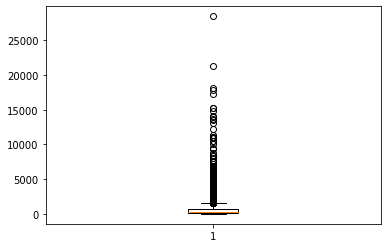

In [33]:
plt.boxplot(fe_train_df['len_post_message'])

Posts are usually very short

In [34]:
print("Min len post message: ", fe_train_df['len_post_message'].min())
print("Max len post message: ", fe_train_df['len_post_message'].max())
print("Median len post message: ", fe_train_df['len_post_message'].median())

Min len post message:  0
Max len post message:  28453
Median len post message:  244.0


In [35]:
fe_train_df['clean_post_message'] = fe_train_df['post_message']

## Special token in text

In [36]:
def count_url(s):
    pattern = r'<URL>'
    if (type(s) == str):
        return len(re.findall(pattern, s))
    return 0

fe_train_df['num_url_in_post_message'] = fe_train_df['clean_post_message'].apply(count_url)

In [37]:
print("Mean num_url_in_post_message when label = 1: ", fe_train_df[fe_train_df['label'] == 1]['num_url_in_post_message'].mean())
print("Mean num_url_in_post_message when label = 0: ", fe_train_df[fe_train_df['label'] == 0]['num_url_in_post_message'].mean())

Mean num_url_in_post_message when label = 1:  0.17558886509635974
Mean num_url_in_post_message when label = 0:  0.45847097687588484


In [38]:
def count_phone(s):
    pattern = r'<PHONE>'
    if (type(s) == str):
        return len(re.findall(pattern, s))
    return 0

In [39]:
def markdown_bold_style(s):
    if (type(s) == str):
        pattern = r'\*\*(.*?)\*\*'
        p = re.compile(pattern)
        temp = p.findall(s)
        num_bold = 0
        for i in temp:
            num_bold += len(i)
        return num_bold
    return 0

In [40]:
def count_all_uppercase_word(s):
    if type(s) == str:
        pattern = r'\b([AĂÂÁẮẤÀẰẦẢẲẨÃẴẪẠẶẬĐEÊÉẾÈỀẺỂẼỄẸỆIÍÌỈĨỊOÔƠÓỐỚÒỒỜỎỔỞÕỖỠỌỘỢUƯÚỨÙỪỦỬŨỮỤỰYÝỲỶỸỴAĂÂÁẮẤÀẰẦẢẲẨÃẴẪẠẶẬĐEÊÉẾÈỀẺỂẼỄẸỆIÍÌỈĨỊOÔƠÓỐỚÒỒỜỎỔỞÕỖỠỌỘỢUƯÚỨÙỪỦỬŨỮỤỰYÝỲỶỸỴAĂÂÁẮẤÀẰẦẢẲẨÃẴẪẠẶẬĐEÊÉẾÈỀẺỂẼỄẸỆIÍÌỈĨỊOÔƠÓỐỚÒỒỜỎỔỞÕỖỠỌỘỢUƯÚỨÙỪỦỬŨỮỤỰYÝỲỶỸỴAĂÂÁẮẤÀẰẦẢẲẨÃẴẪẠẶẬĐEÊÉẾÈỀẺỂẼỄẸỆIÍÌỈĨỊOÔƠÓỐỚÒỒỜỎỔỞÕỖỠỌỘỢUƯÚỨÙỪỦỬŨỮỤỰYÝỲỶỸỴAĂÂÁẮẤÀẰẦẢẲẨÃẴẪẠẶẬĐEÊÉẾÈỀẺỂẼỄẸỆIÍÌỈĨỊOÔƠÓỐỚÒỒỜỎỔỞÕỖỠỌỘỢUƯÚỨÙỪỦỬŨỮỤỰYÝỲỶỸỴAĂÂÁẮẤÀẰẦẢẲẨÃẴẪẠẶẬĐEÊÉẾÈỀẺỂẼỄẸỆIÍÌỈĨỊOÔƠÓỐỚÒỒỜỎỔỞÕỖỠỌỘỢUƯÚỨÙỪỦỬŨỮỤỰYÝỲỶỸỴA-Z]{2,})\b'
        upperword = re.finditer(pattern, s)
        return sum(1 for _ in upperword)
    return 0
# count_all_uppercase_word('TIN NÓNG')

In [42]:
def countQuestionMark(s):
    if (type(s) == str):
        p = re.compile(r'\?')
        return len(p.findall(s))
    return 0
def countExclamationMark(s):
    if (type(s) == str):
        p = re.compile(r'!')
        return len(p.findall(s))
    return 0
def countQuoteMark(s):
    if (type(s) == str):
        p = re.compile(r'"')
        return int(len(p.findall(s))/2)
    return 0
def countComma(s):
    if (type(s) == str):
        p = re.compile(r',')
        return int(len(p.findall(s)))
    return 0
def countDot(s):
    if (type(s) == str):
        p = re.compile(r'\.')
        return int(len(p.findall(s)))
    return 0

def countEmoji(s):
    if type(s) == str:
        emoticons = re.finditer(r'[\U0001F300-\U0001FAD6]', s)
        return sum(1 for _ in emoticons)
    return 0
def countTag(s):
    if type(s) == str:
        pattern = r'#([\w]+)'
        tags = re.finditer(pattern, s)
        return sum(1 for _ in tags)
    return 0
def countUpper(s):
    if (type(s) == str):
        return sum(1 for c in s if c.isupper()) or 0
    return 0
def coleman_liau_score(s):
    if type(s) == str:
        return textstat.coleman_liau_index(s)
    return 12
# countUpper('NÓNG')
# countTag('282,2.5448315543444e+18,"#Share & #tag')
# countDot("Xin,, , .?\"!c\"\"\"\..\"??ha,o tat ca moi nguo\"!!i ???")

In [43]:
fe_train_df['num_phone_in_post_message'] = fe_train_df['clean_post_message'].apply(count_url)
fe_train_df['num_bold_char_in_message'] = fe_train_df['clean_post_message'].apply(markdown_bold_style)
fe_train_df['num_upper_char'] = fe_train_df['post_message'].apply(countUpper)
fe_train_df['num_question_mark'] = fe_train_df['clean_post_message'].apply(countQuestionMark)
fe_train_df['num_exclamation_mark'] = fe_train_df['clean_post_message'].apply(countExclamationMark)
fe_train_df['num_quote_mark'] = fe_train_df['clean_post_message'].apply(countQuoteMark)
fe_train_df['num_comma'] = fe_train_df['clean_post_message'].apply(countComma)
fe_train_df['num_dot'] = fe_train_df['clean_post_message'].apply(countDot)
fe_train_df['num_tag'] = fe_train_df['clean_post_message'].apply(countTag)
fe_train_df['num_emoji'] = fe_train_df['clean_post_message'].apply(countEmoji)

In [44]:
print("Mean num_bold_char_in_message when label = 1: ", fe_train_df[fe_train_df['label'] == 1]['num_bold_char_in_message'].mean())
print("Mean num_bold_char_in_message when label = 0: ", fe_train_df[fe_train_df['label'] == 0]['num_bold_char_in_message'].mean())
print("Mean num_phone_in_post_message when label = 1: ", fe_train_df[fe_train_df['label'] == 1]['num_phone_in_post_message'].mean())
print("Mean num_url_in_phone_message when label = 0: ", fe_train_df[fe_train_df['label'] == 0]['num_phone_in_post_message'].mean())

Mean num_bold_char_in_message when label = 1:  12.21627408993576
Mean num_bold_char_in_message when label = 0:  13.576687116564417
Mean num_phone_in_post_message when label = 1:  0.17558886509635974
Mean num_url_in_phone_message when label = 0:  0.45847097687588484


# Handle emoji

In [45]:
emoji_dict = dict()
with open('./emoji_dict.json', 'r') as f:
    emoji_dict = json.load(f)

In [46]:
def replaceEmoji(s):
    if (type(s) == str):
        global emoji_dict
        s_clean = s
        for e in emoji_dict.keys():
            s_clean = s_clean.replace(e, emoji_dict[e])
        return s_clean
    return s

In [47]:
fe_train_df['clean_post_message'] = fe_train_df['clean_post_message'].apply(replaceEmoji)

In [48]:
fe_train_df[fe_train_df['id'] == 27][['post_message', 'clean_post_message']]

,post_message,clean_post_message
27,Kỳ án HDH.đã tìm ra chứng cứ ngoại phạm cho HD...,Kỳ án HDH.đã tìm ra chứng cứ ngoại phạm cho HD...
826,📣 SÁNG NAY KHÔNG CÓ CA MẮC MỚI\n\n🦠 Tổng số ca...,loa phóng thanh SÁNG NAY KHÔNG CÓ CA MẮC MỚI\n...


# Misc Clean

In [49]:
def miscClean(s, tokenize=True):
    remove_misc_s = s.replace('<URL>', '')
    remove_misc_s = remove_misc_s.replace('<PHONE>', '')
    
    if tokenize:
        remove_misc_s_list = annotator.tokenize(remove_misc_s)
        remove_misc_s = ''
        for s in remove_misc_s_list:
            for w in s:
#                 if (is_digit(w)):
#                     remove_misc_s += "<number> "
#                 elif (w in string.punctuation):
#                     remove_misc_s += "<punct> "
#                 else:
                    remove_misc_s += w + " "
    
#     remove_misc_s = remove_misc_s.lower()
    remove_misc_s = remove_misc_s.strip()
    return remove_misc_s

miscClean('Phía nguyên đơn yêu cầu tòa xem xét. hủy toàn bộ quyết định của UBND <URL> về việc công nhận Hội đồng quản trị Trường đại học Hoa Sen. #đạihọcHoaSen')
# re.sub('[0-9]', " <number> ", "0981298767")
# re.sub('''[!()\-\[\]{};:'"\\,<>./?@#*_]''', " <punch> ", "haha??HAHAH")

'Phía nguyên_đơn yêu_cầu toà xem_xét . huỷ toàn_bộ quyết_định của UBND về việc công_nhận Hội_đồng_quản_trị Trường đại_học Hoa_Sen . # đạihọcHoaSen'

# Statistic of Part of Speech (POS)

In [50]:
def count_POS_tag(s):
    s = s.replace('<URL>', '')
    s = s.replace('<PHONE>', '')
    
    pos_data = annotator.pos_tag(s)
    pos_r = {"Ny": 0, "V": 0, "N": 0, "M": 0, "E": 0,"CH": 0,"Np": 0,"R": 0,"C": 0, "Vb": 0, "Z": 0, "A": 0, "Nu": 0, "Cc": 0, "P": 0, "L": 0, "Nc": 0, "T": 0, "Nb": 0, "X": 0, "I": 0, "B": 0, "Y": 0, "Ni": 0}
    if (len(pos_data) > 0):
        for p in pos_data[0]:
            pos_r[p[1]] += 1
    return pos_r
fe_train_df['arr_POS'] = fe_train_df['post_message'].apply(count_POS_tag)

In [51]:
a = {"Ny": 0, "V": 0, "N": 0, "M": 0, "E": 0,"CH": 0,"Np": 0,"R": 0,"C": 0, "Vb": 0, "Z": 0, "A": 0, "Nu": 0, "Cc": 0, "P": 0, "L": 0, "Nc": 0, "T": 0, "Nb": 0, "X": 0, "I": 0, "B": 0, "Y": 0, "Ni": 0}
list_post = list(a.keys())
list_post

['Ny',
 'V',
 'N',
 'M',
 'E',
 'CH',
 'Np',
 'R',
 'C',
 'Vb',
 'Z',
 'A',
 'Nu',
 'Cc',
 'P',
 'L',
 'Nc',
 'T',
 'Nb',
 'X',
 'I',
 'B',
 'Y',
 'Ni']

In [52]:
def dict_POS_to_column(s):
#     print(s)
    if (len(s)):
        return tuple(s.values())
    return (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

In [53]:
fe_train_df[['Ny', 'V', 'N', 'M', 'E', 'CH', 'Np', 'R', 'C', 'Vb', 'Z', 'A', 'Nu', 'Cc', 'P', 'L', 'Nc', 'T', 'Nb', 'X', 'I', 'B', 'Y', 'Ni']] = fe_train_df['arr_POS'].apply(dict_POS_to_column).apply(pd.Series)

In [54]:
fe_train_df['clean_post_message'] = fe_train_df['clean_post_message'].apply(miscClean, args=(True, ))
fe_train_df['coleman_liau_score'] = fe_train_df['clean_post_message'].apply(coleman_liau_score)

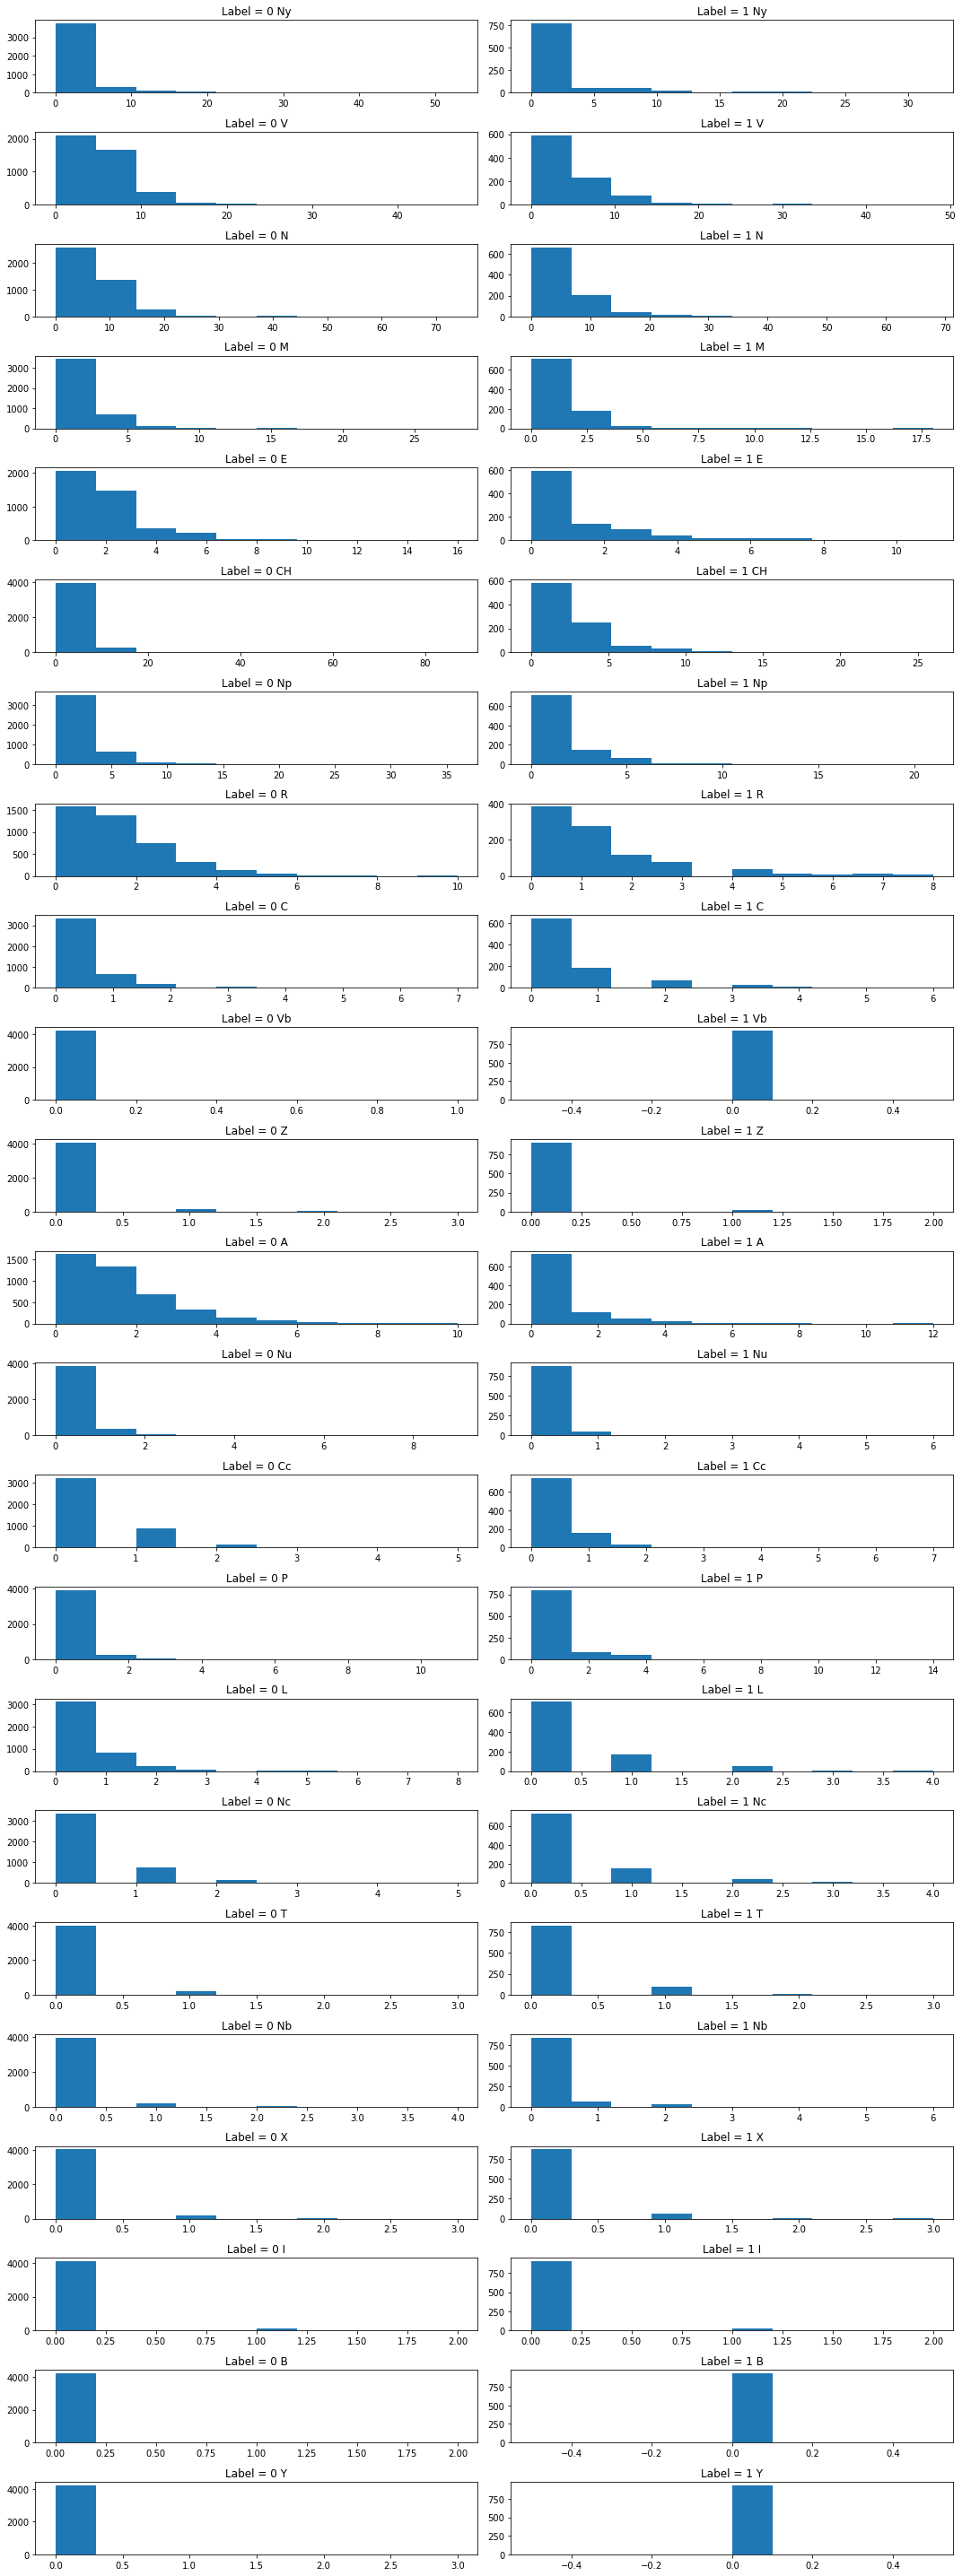

In [55]:
fig, ax = plt.subplots(23, 2, figsize=(15,40))
for i in range(0, 23):
#     fig.tight_layout(pad=3.0)
    ax[i, 0].hist(fe_train_df[fe_train_df['label'] == 0][list_post[i]])
    ax[i, 0].set_title('Label = 0 ' + list_post[i])
    ax[i, 1].hist(fe_train_df[fe_train_df['label'] == 1][list_post[i]])
    ax[i, 1].set_title('Label = 1 ' + list_post[i])
fig.tight_layout()

Some tag might be useful for fake news detection

# Check sentence sentiment

In [56]:
print(sentiment('Thuận Lợi có ca dương tính CV19 rồi đó, mọi người ở Đồng Xoài cẩn thận nhé. Cố gắng an toàn cho qua mùa dịch này cả nhà ơi...\nBình Phước ơi gắng lên!'))

positive


In [57]:
def check_sentiment(s):
    stm = sentiment(s)
    if (stm == 'positive'):
        return 1
    elif (stm == 'negative'):
        return -1
    return 0

In [58]:
fe_train_df['sentiment'] = fe_train_df['post_message'].apply(check_sentiment)

<AxesSubplot:>

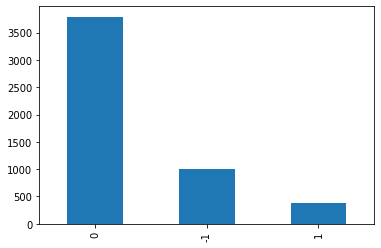

In [59]:
fe_train_df['sentiment'].value_counts().plot(kind='bar')

In [60]:
gb_sent_label = fe_train_df.groupby(['sentiment', 'label']).size().unstack()

In [61]:
bottom = gb_sent_label[0].to_list()
top = gb_sent_label[1].to_list()

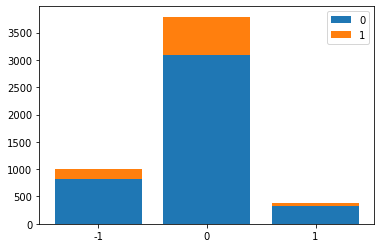

In [62]:
fig, ax = plt.subplots()
ax.bar(['-1', '0', '1'], bottom, label='0')
ax.bar(['-1', '0', '1'], top, label='1', bottom=bottom)
ax.legend()

Mostly neutral

# Apply for test

In [63]:
fe_train_df.columns

Index(['id', 'user_name', 'post_message', 'timestamp_post', 'num_like_post',
       'num_comment_post', 'num_share_post', 'label', 'num_post', 'month_post',
       'day_post', 'weekday_post', 'hour_post', 'session_of_day',
       'len_post_message', 'clean_post_message', 'num_url_in_post_message',
       'num_phone_in_post_message', 'num_bold_char_in_message',
       'num_upper_char', 'num_question_mark', 'num_exclamation_mark',
       'num_quote_mark', 'num_comma', 'num_dot', 'num_tag', 'num_emoji',
       'arr_POS', 'Ny', 'V', 'N', 'M', 'E', 'CH', 'Np', 'R', 'C', 'Vb', 'Z',
       'A', 'Nu', 'Cc', 'P', 'L', 'Nc', 'T', 'Nb', 'X', 'I', 'B', 'Y', 'Ni',
       'coleman_liau_score', 'sentiment'],
      dtype='object')

In [64]:
drop_col = ['post_message', 'arr_POS']
fe_train_df.fillna("-999", inplace=True)
fe_train_df[[f for f in fe_train_df.columns if f not in drop_col]].to_csv('clean_train_df_ext.csv', index=False)
# [f for f in fe_train_df.columns if f not in drop_col]

In [65]:
fe_test_df = test_df.copy()

In [66]:
fe_test_df[['num_like_post', 'num_comment_post', 'num_share_post']] = fe_test_df[['num_like_post', 'num_comment_post', 'num_share_post']].replace('unknown', np.nan)
fe_test_df[['num_like_post', 'num_comment_post', 'num_share_post']] = fe_test_df[['num_like_post', 'num_comment_post', 'num_share_post']].fillna('-999')

fe_test_df['num_like_post'] = fe_test_df['num_like_post'].apply(handle_num_like_post).astype(float)
fe_test_df['num_comment_post'] = fe_test_df['num_comment_post'].apply(handle_num_comment_post).astype(float)
fe_test_df['num_share_post'] = fe_test_df['num_share_post'].apply(handle_num_share_post).astype(float)

fe_test_df.loc[fe_test_df['num_like_post'] > 150000000, 'timestamp_post'] = fe_test_df[fe_test_df['num_like_post'] > 150000000]['num_like_post']
fe_test_df.loc[fe_test_df['num_like_post'] > 150000000, 'num_like_post'] = -999

fe_test_df.loc[fe_test_df['num_comment_post'] > 150000000, 'timestamp_post'] = fe_test_df[fe_test_df['num_comment_post'] > 150000000]['num_comment_post']
fe_test_df.loc[fe_test_df['num_comment_post'] > 150000000, 'num_comment_post'] = -999

fe_test_df.loc[fe_test_df['num_share_post'] > 150000000, 'timestamp_post'] = fe_test_df[fe_test_df['num_share_post'] > 150000000]['num_share_post']
fe_test_df.loc[fe_test_df['num_share_post'] > 150000000, 'num_share_post'] = -999

#Time
fe_test_df['timestamp_post'] = pd.to_datetime(fe_test_df['timestamp_post'], unit='s')
fe_test_df['month_post'] = fe_test_df['timestamp_post'].dt.month
fe_test_df['day_post'] = fe_test_df['timestamp_post'].dt.day
fe_test_df['weekday_post'] = fe_test_df['timestamp_post'].dt.weekday
fe_test_df['hour_post'] = fe_test_df['timestamp_post'].dt.hour
fe_test_df['session_of_day'] = fe_test_df['hour_post'].apply(session_of_day)

# Text statistic
fe_test_df['post_message'].fillna("", inplace=True)
fe_test_df['len_post_message'] = [len(t) for t in fe_test_df['post_message']]
fe_test_df['clean_post_message'] = fe_test_df['post_message']
fe_test_df['num_url_in_post_message'] = fe_test_df['clean_post_message'].apply(count_url)
fe_test_df['num_phone_in_post_message'] = fe_test_df['clean_post_message'].apply(count_url)
fe_test_df['num_bold_char_in_message'] = fe_test_df['clean_post_message'].apply(markdown_bold_style)
fe_test_df['num_upper_char'] = fe_test_df['post_message'].apply(countUpper)
fe_test_df['num_question_mark'] = fe_test_df['clean_post_message'].apply(countQuestionMark)
fe_test_df['num_exclamation_mark'] = fe_test_df['clean_post_message'].apply(countExclamationMark)
fe_test_df['num_quote_mark'] = fe_test_df['clean_post_message'].apply(countQuoteMark)
fe_test_df['num_comma'] = fe_test_df['clean_post_message'].apply(countComma)
fe_test_df['num_dot'] = fe_test_df['clean_post_message'].apply(countDot)
fe_test_df['num_tag'] = fe_test_df['clean_post_message'].apply(countTag)
fe_test_df['num_emoji'] = fe_test_df['clean_post_message'].apply(countEmoji)
fe_test_df['clean_post_message'] = fe_test_df['clean_post_message'].apply(replaceEmoji)

unique_user_test = fe_test_df['user_name'].value_counts()
fe_test_df['num_post'] = fe_test_df['user_name'].map(unique_user_test)

fe_test_df['clean_post_message'] = fe_test_df['clean_post_message'].apply(miscClean, args=(True, ))
fe_test_df['coleman_liau_score'] = fe_test_df['clean_post_message'].apply(coleman_liau_score)

In [67]:
fe_test_df['arr_POS'] = fe_test_df['post_message'].apply(count_POS_tag)

In [68]:
fe_test_df[['Ny', 'V', 'N', 'M', 'E', 'CH', 'Np', 'R', 'C', 'Vb', 'Z', 'A', 'Nu', 'Cc', 'P', 'L', 'Nc', 'T', 'Nb', 'X', 'I', 'B', 'Y', 'Ni']] = fe_test_df['arr_POS'].apply(dict_POS_to_column).apply(pd.Series)

In [69]:
fe_test_df['sentiment'] = fe_test_df['post_message'].apply(check_sentiment)

In [70]:
fe_test_df['coleman_liau_score'] = fe_test_df['clean_post_message'].apply(coleman_liau_score)

In [71]:
# Check if train have feature that test not have
[x for x in fe_train_df.columns.to_list() if x not in fe_test_df.columns.to_list()]

['label']

In [ ]:
drop_col = ['post_message', 'arr_POS']
fe_test_df.fillna("-999", inplace=True)
fe_test_df[[f for f in fe_test_df.columns if f not in drop_col]].to_csv('clean_final_test_df.csv', index=False)
# [f for f in fe_train_df.columns if f not in drop_col]

In [72]:
fe_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         1646 non-null   int64         
 1   user_name                  1646 non-null   object        
 2   post_message               1646 non-null   object        
 3   timestamp_post             1612 non-null   datetime64[ns]
 4   num_like_post              1646 non-null   float64       
 5   num_comment_post           1646 non-null   float64       
 6   num_share_post             1646 non-null   float64       
 7   month_post                 1612 non-null   float64       
 8   day_post                   1612 non-null   float64       
 9   weekday_post               1612 non-null   float64       
 10  hour_post                  1612 non-null   float64       
 11  session_of_day             1646 non-null   int64         
 12  len_po

In [73]:
fe_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 54 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         5172 non-null   int64  
 1   user_name                  5172 non-null   object 
 2   post_message               5172 non-null   object 
 3   timestamp_post             5172 non-null   object 
 4   num_like_post              5172 non-null   float64
 5   num_comment_post           5172 non-null   float64
 6   num_share_post             5172 non-null   float64
 7   label                      5172 non-null   int64  
 8   num_post                   5172 non-null   int64  
 9   month_post                 5172 non-null   object 
 10  day_post                   5172 non-null   object 
 11  weekday_post               5172 non-null   object 
 12  hour_post                  5172 non-null   object 
 13  session_of_day             5172 non-null   int64